# Running OpenDrift

<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#000000; border-left: solid #000000 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Objective: </b> Run lagrangian release experiments using OpenDrift. </p>
<p style='margin-left:1em;'>
Opendrift.py contains Opendrift_run (class) that runs a particle release experiment with chosen particle dispersion parameters including multiple seeding times and/or locations habitat settlement type of model vertical parameters.
</p>
<p style='margin-left:1em;'>
Dec - 2023 | Mireya M. Montano | mireya.mmor@gmail.com
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>


## Extracting Data

As part of the Moana Project the data for the Bay of Plenty (region of study) is available through [THREDDS](http://thredds.moanaproject.org:6443/thredds/catalog/moana/catalog.html) server. Therefore we can just call the desired file providing the link.

In [1]:
import os

THREDDS_SERVER = "http://thredds.moanaproject.org:6443/thredds/dodsC/moana/"
BOP_HIS_PATH = f"BoP_1km/his/bop1km_v2_his_"

PATH = os.path.join(THREDDS_SERVER, BOP_HIS_PATH)

## Parameters for OpenDrift_run
### File/environment related parameters
With environment parameters I mean parameters that are not precisely related with OpenDrift but more so about the data to ingest. 
- file_path (str) - path of the file where the velocities are located. Make sure the files provided cover the full period of advection
- outdir (str) - path of the directory where to save the output
- id (str Optional) - identifier for the experiment. In case of running multiple experiments over the same dates with different parameters for example for experiments with no stranding parameter an id could be **ns**
- vars_dict (dict Optional) - Dictionary containing the names associated to the lon lat and mask variables within the file. ROMS example:
  - {"depth": "h" "time": "ocean_time"}

In [2]:
year = 2003
month = 1
m1 = "%02d" % month
m2 = "%02d" % (month + 1)
file_path = [f"{PATH}{year}{m1}.nc", f"{PATH}{year}{m2}.nc"]
outdir = os.path.join(os.getcwd(), "output")
vars_dict = {"depth": "h", "time": "ocean_time"}  # ROMS variable names

### Particle release and OpenDrift configuration parameters

In this portion we define the particle release and Opendrfit configuration related parameters. 
- log_level (int): Logging information for Opendrfit. Default: 50. 50 - No information 20 For a certain amount 0 for all the debugging
- opendrift_reader (str): Reader for the files see OpenDrift for more information. In this example we use "reader_ROMS_native_MOANA"
- opendrift_model (str): OpenDrift module to use. In this example we use "OceanDrift"
- number_of_particles (int): Number of particles to deploy per location
- cluster_std (int): For a Lagrangian analyses a cluster of particles is recommended. Therefore the defined number_of_particles is going to be released on a cluster with a defined deviation (cluster_std). This value depends on the model grid. Used in BoP experiment 0.003 (~3 km)
- random_depth (boolean or int): If True is going to release the particles in each location at random depths through the water column. If a number is given this will be the limit i.e. if 20 is given the particles are going to be released between the surface and 20 meters
- depth (boolean or int): If the user prefers to deploy all the particles at a specific depth this can also be done with defining random_depth as false and giving a value to depth instead.


<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#69337A; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
Regarding the release locations we provide two options: <b>release on isobath</b> or <b>release_locations</b>. One should be chosen.

- Release on isobath
<p style='margin-left:3em;'> With the release on isobath option, the user provides a desired isobath to follow for the releases as seen in Chapter 2 and 4 of Montano, 2023. </p>
<p style='margin-left:3em;'> With this option parameters such as spacing_locations, ignore_first and/or ignore_last must be provided </p>

- Release on location  
<p style='margin-left:3em;'> With this option, the user must provide the desired release locations. No limits. </p>
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>

- release_on_isobath (int): If True the script is going to find locations along the given isobath (i.e. 200 will find locations along the 200 m isobath). Either this or release_locations should be provided
  - spacing_locations (int): If release on isobath is true define the spacing between locations this depends and type of the grid. Choose wisely.
  - ignore_first (int): Ignores the first (defined number) of locations given useful when using release on isobath. Default 0
  - ignore_last (int): Ignores the last (defined number) of locations given useful when using release on isobath. Default -1
- release_on_locations (tuple): If True it must contain the coordinates of the release locations. 

In [3]:
log_level = 20
opendrift_reader = "reader_ROMS_native"
opendrift_model = "OceanDrift"
id = "control"
number_of_particles = 10
cluster_std = 0.003
random_depth = 20

release_on_isobath = 65
spacing_locations = 20
ignore_first = 8
ignore_last = 9

- release_interval (int): Particle release interval in hours. Default 3
- advection_duration (int): Expected duration of advection of particles in seconds. Default (60x24x3600)
- max_speed (int): maximum speed particles are allowed to reach in m/s. Default 5
- horizontal_diffusivity (int): Particle release horizontal diffusivity. Default: 0.1
- advection_scheme (str): Advection scheme of the particle release. Default: "runge-kutta4"
- coastline_action (str): What happens to the particle when it reaches the coast. Default 'stranding'
- time_step_advection (int): Advection time step in seconds. Default 900 (15 minutes)
- time_step_output (int): Output time step in seconds. Default 3600x3 (Every 3 hours)

In [4]:
release_interval = 12
release_until = 5 * 24 * 3600  # only the first five days
advection_duration = (
    15 * 24 * 3600
)  # advection lasting for 30 days or after all particles have stranded
max_speed = 5
advection_scheme = "runge-kutta4"
horizontal_diffusivity = 0.1
time_step_advection = 900
time_step_output = 3600 * 3
coastline_action = "stranding"

<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#CC5500; border-left: solid #FFA500 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
The following parameters are not strictly necessary but there are some of the options that were used throughout the aforementioned Thesis
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>

### Vertical Motion Parameters
- vertical_motion (boolean): If True all the vertical parameters below should be provided. Default True
- vertical_diffusivity (int): Value for vertical diffusivity. Check with your hydrodynamic model. Default 0.001
- vertical_mixing_timestep (int): Vertical mixing timestep in seconds. Default 90

In [5]:
vertical_motion = True
vertical_diffusivity = 0.001
vertical_mixing_timestep = 90

### Behaviour Parameters
- behaviour (boolean): If True parameters such as maximum age minimum settlement age and maximum depth a particle can reach can be defined
- max_age_seconds (int): In seconds Default: None. Note make sure is less or the same as advection_duration
- min_settlemente_age (int): Minimum settlement age in seconds. Default 0
- maximum_depth (int): Maximum depth a particle can reach. Default False


### Habitat Parameters
- habitat (boolean or str) If True a path of the shapefile with the habitats must be provided.

### Other Parameters
- first_and_last_position (boolean) If True a text file containing the first and last position of the particles is given.


In [6]:
first_and_last_position = True

To run

In [7]:
import xarray as xr

ds = xr.open_mfdataset(file_path)

INFO:root:--- Creating output directory
18:28:49 INFO    opendrift.models.basemodel:538: OpenDriftSimulation initialised (version 1.10.6 / v1.0.1-3263-gdb922eb)
18:28:49 INFO    opendrift.readers.reader_ROMS_native:86: Opening dataset: ['http://thredds.moanaproject.org:6443/thredds/dodsC/moana/BoP_1km/his/bop1km_v2_his_200301.nc', 'http://thredds.moanaproject.org:6443/thredds/dodsC/moana/BoP_1km/his/bop1km_v2_his_200302.nc']
18:28:49 INFO    opendrift.readers.reader_ROMS_native:88: Opening files with MFDataset
18:28:49 INFO    opendrift.readers.reader_ROMS_native:176: Read GLS parameters from file.
18:28:49 WARNING opendrift.readers.basereader.structured:44: No proj string or projection could be derived, using 'fakeproj'. This assumes that the variables are structured and gridded approximately equidistantly on the surface (i.e. in meters). This must be guaranteed by the user. You can get rid of this warning by supplying a valid projection to the reader.
18:28:49 INFO    opendrift.reade

--- OpenDrift Configuration set
--- Particles seeded from  00:00 01/01/2003 to  00:00 01/06/2003 every 12 hours
--- Finding release locations over the 65m isobath
--- 11 release locations identified over the 65m isobath
--- Number of release locations: 11
--- Particles released at random depths throughout from 20 to the surface


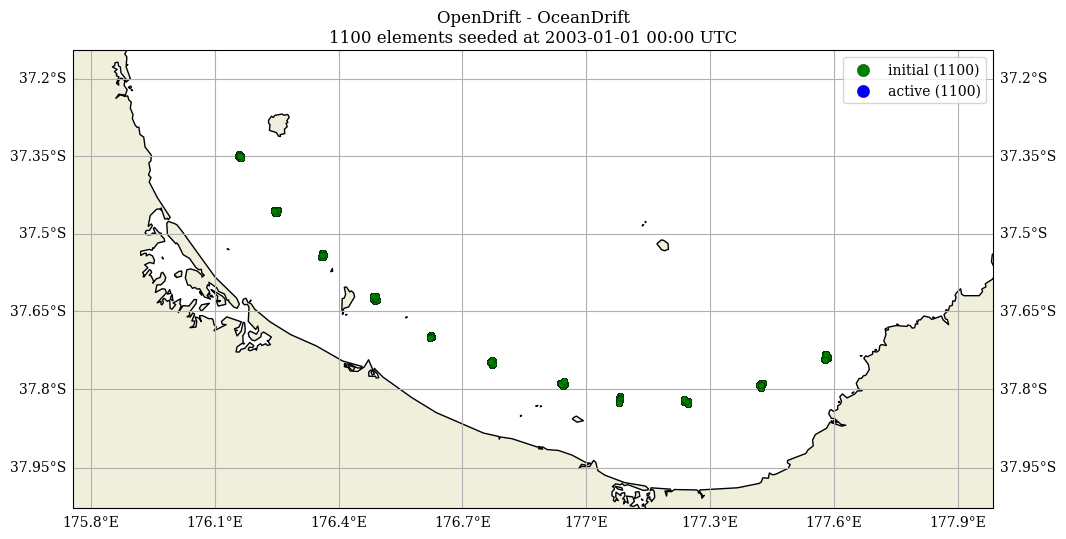

18:29:14 INFO    opendrift.models.basemodel:2587: Fallback values will be used for the following variables which have no readers: 
18:29:14 INFO    opendrift.models.basemodel:2590: 	x_wind: 0.000000
18:29:14 INFO    opendrift.models.basemodel:2590: 	y_wind: 0.000000
18:29:14 INFO    opendrift.models.basemodel:2590: 	ocean_vertical_diffusivity: 0.001000
18:29:14 INFO    opendrift.models.basemodel:2590: 	sea_surface_wave_significant_height: 0.000000
18:29:14 INFO    opendrift.models.basemodel:2590: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
18:29:14 INFO    opendrift.models.basemodel:2590: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
18:29:14 INFO    opendrift.models.basemodel:2590: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
18:29:14 INFO    opendrift.models.basemodel:2590: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
18:29:14 INFO    opendrift.models.basemodel:2590: 	turbulent_kinetic_energy: 

--- Particles seeded starting OpenDrift run


18:29:15 INFO    opendrift.models.basemodel:2878: 2003-01-01 00:00:00 - step 1 of 1440 - 110 active elements (0 deactivated)
18:29:20 INFO    opendrift.readers.reader_ROMS_native:405: Time: 0:00:00.770537
18:29:46 INFO    opendrift.models.basemodel:2878: 2003-01-01 00:15:00 - step 2 of 1440 - 110 active elements (0 deactivated)
18:29:46 INFO    opendrift.models.basemodel:2878: 2003-01-01 00:30:00 - step 3 of 1440 - 110 active elements (0 deactivated)
18:29:46 INFO    opendrift.models.basemodel:2878: 2003-01-01 00:45:00 - step 4 of 1440 - 110 active elements (0 deactivated)
18:29:47 INFO    opendrift.models.basemodel:2878: 2003-01-01 01:00:00 - step 5 of 1440 - 110 active elements (0 deactivated)
18:30:03 INFO    opendrift.models.basemodel:2878: 2003-01-01 01:15:00 - step 6 of 1440 - 110 active elements (0 deactivated)
18:30:03 INFO    opendrift.models.basemodel:2878: 2003-01-01 01:30:00 - step 7 of 1440 - 110 active elements (0 deactivated)
18:30:03 INFO    opendrift.models.basemodel:2

NameError: name 'o' is not defined

In [8]:
from Lagrangian_Analyses.opendrift import opendrift_run

particle_experiment = opendrift_run(
    file_path=[f"{PATH}{year}{m1}.nc", f"{PATH}{year}{m2}.nc"],
    outdir=os.path.join(os.getcwd(), "output"),
    vars_dict=vars_dict,
    id=id,
    log_level=log_level,
    opendrift_reader=opendrift_reader,
    opendrift_model=opendrift_model,
    number_of_particles=number_of_particles,
    cluster_std=cluster_std,
    random_depth=random_depth,
    release_on_isobath=release_on_isobath,
    spacing_locations=spacing_locations,
    ignore_first=ignore_first,
    ignore_last=ignore_last,
    release_interval=release_interval,
    release_until=release_until,
    advection_duration=advection_duration,
    max_speed=max_speed,
    advection_scheme=advection_scheme,
    horizontal_diffusivity=horizontal_diffusivity,
    time_step_advection=time_step_advection,
    time_step_output=time_step_output,
    coastline_action=coastline_action,
    vertical_motion=vertical_motion,
    vertical_diffusivity=vertical_diffusivity,
    vertical_mixing_timestep=vertical_mixing_timestep,
    first_and_last_position=first_and_last_position,
)
particle_experiment.run()

### Output files:
- "%yyyy%mm_Particles_{id}.nc" (netCDF) OpenDrift Output. File containing lat lon z trajectory status age_seconds and origin_marker associated to each released particle.
  
*Optional*:
- "%yyyy%mm_Particles_{id}.txt" (.txt) File containing the initial (lon, lat), final (lon, lat) coordinates and final status of the released particles. (stranded, active, dead)